# What is this?

This notebook generates Figure 4 in the manuscript, as well as the table in Appendix D.


In [1]:
import UCI_classification.datasets as datasets
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.pyplot import figure, savefig
import numpy as np

In [2]:
def parse_hparams(result_file_name):
    """
    Output: Ctx_HPC
                Context Pandas dataframe of HyperParameters configuration
    """
    lines = open(result_file_name, "r").read().splitlines()
    for l in lines:
        if l[:3] == "HYP":
            Ctx_HPC = pd.DataFrame(eval(l[4:]))
            Ctx_HPC['HPC_id'] = Ctx_HPC.index
            break
    return Ctx_HPC



def parse_run_result_for_single_dataset(result_file_name, hparam_ids):
    """
    Input: path to a result file
    Output: Lst_HpId_RunInfo
                a list indexed by HpId
    """
    lines = open(result_file_name, "r").read().splitlines()
    res_lines = [l for l in lines if l[:3] == "RES"]
    results = (''.join(res_lines)).split("RES ")[1:]
    
    header_row = results[0]
    header_row_new = header_row.split(',')
    header_row_new[0] = "HPC_id"
    header_row = ",".join(header_row_new)

    
    Output_str = [header_row for hparam_id in hparam_ids]
    
    # results_hparam_id = {}
    for row in results[1:]:
        hparam_id = int(row.split(',')[0])
        Output_str[hparam_id] += "\n" + row

    Output = [pd.read_csv(StringIO(res))  for res in Output_str]
    return Output

def get_row_with_highest_val_acc(result):
    if result.shape[0] == 0:
        return float('nan')
    best_row = result.iloc[result['val_acc_sm'].argmax()]
    return best_row

def get_tst_acc_at_highest_val_acc(result):
    return get_row_with_highest_val_acc(result)['tst_acc']


def get_acc_tbl(DSNames, AlgoName):
    # Dictionary with
    #     key = dataset name (DSName)
    #     value = a list indexed by the hyperparameter configuration (HPC) and items 
    #               are the training curves 
    #               (training accuracy, validation accuracy, testing accuracy)
    Dct_DSName_Lst_HPC_RunInfo = {}
    
    

    for DSName in DSNames:
        result_file_name = "results/%s/%s.out"% (AlgoName, DSName)

        Ctx_HPC = parse_hparams(result_file_name)
        HPC_ids = Ctx_HPC['HPC_id'].tolist()
        
        RunInfo = parse_run_result_for_single_dataset(result_file_name, HPC_ids)
        if RunInfo[0].shape[0]>0:
            Dct_DSName_Lst_HPC_RunInfo[DSName] = RunInfo

    DSNames = list(Dct_DSName_Lst_HPC_RunInfo.keys())


    
    
    # Dictionary with
    #     key = dataset name (DSName)
    #     value = a table with rows indexed by the hyperparameter configuration (HPC) 
    #             records the testing accuracy at the epoch when the (smoothed) validation accuracy is the highest
    Dct_DSName_Tbl_HPC_Acc = {DSName: 
        pd.DataFrame.transpose(
            pd.concat( [get_row_with_highest_val_acc((RunInfo) )
                        for RunInfo in Lst_HPC_RunInfo],
                     axis=1)
        ) for DSName, Lst_HPC_RunInfo in Dct_DSName_Lst_HPC_RunInfo.items()}


    
    
    # Table with rows indexed by the dataset name (DSName)
    # records the testing accuracy at the epoch when the (smoothed) validation accuracy is the highest over all hyperparameters
    Acc_tbl = pd.DataFrame(
        list(zip(DSNames,[get_tst_acc_at_highest_val_acc(Dct_DSName_Tbl_HPC_Acc[DSName])  
                          for DSName in DSNames])), 
        columns= ["DSName", AlgoName]) 

    
    

    return Acc_tbl


In [3]:
datalist = 'all'
DSNames = datasets.get_data_list(datalist)

HANN100 = get_acc_tbl(DSNames,"HANN100OCE")
HANN15 = get_acc_tbl(DSNames,"HANN15OCE")
HANN = pd.merge(HANN100,HANN15,how='inner',on="DSName")

In [4]:
wu = pd.read_csv("wu2018tableA1.csv")
wu[['DENN','SNN', 'SNN-our']] *= 100
wu = wu.rename(columns={"dataset_name":"DSName"})

In [5]:
joint = pd.merge(HANN,wu,how='inner',on="DSName")
joint["diff_HANN15_DENN"] = joint['HANN15OCE'] - joint['DENN']
joint["diff_HANN15_SNN"] = joint['HANN15OCE'] - joint['SNN']
joint["diff_HANN100_DENN"] = joint['HANN100OCE'] - joint['DENN']
joint["diff_HANN100_SNN"] = joint['HANN100OCE'] - joint['SNN']

In [6]:
diff_cols = [col for col in list(joint.columns) if col[:4]=="diff"]
diffs = joint.filter(items=["DSName"]+diff_cols)
df = pd.melt(diffs, value_vars = diff_cols,id_vars="DSName")

In [7]:
lmap = lambda f,x: list(map(f,x))
df['Y'] = lmap(lambda x: x.split("_")[2],df['variable'])
df['X'] = lmap(lambda x: x.split("_")[1][4:],df['variable'])

In [8]:
df

,DSName,variable,value,Y,X
0,abalone,diff_HANN15_DENN,-2.97,DENN,15
1,acute-inflammation,diff_HANN15_DENN,0.00,DENN,15
2,acute-nephritis,diff_HANN15_DENN,0.00,DENN,15
3,adult,diff_HANN15_DENN,-0.48,DENN,15
4,annealing,diff_HANN15_DENN,-28.00,DENN,15
...,...,...,...,...,...
475,wine,diff_HANN100_SNN,2.27,SNN,100
476,wine-quality-red,diff_HANN100_SNN,2.00,SNN,100
477,wine-quality-white,diff_HANN100_SNN,-2.70,SNN,100
478,yeast,diff_HANN100_SNN,-2.42,SNN,100


In [9]:
def plot_ridge_line(vals,ax):
    mean_diff = round(np.nanmedian(vals),1)
    q80_diff = round(np.nanquantile(vals,0.8),1)
    q20_diff = round(np.nanquantile(vals,0.2),1)
    ax.axvline( mean_diff, color = 'k',linestyle="--")
    ax.axvline( q20_diff, color = 'k',linestyle=":")
    ax.axvline( q80_diff, color = 'k',linestyle=":")
    sns.kdeplot(vals, color ='k',ax=ax)
    sns.rugplot(vals,height=.1,ax=ax)
    ax.grid(axis='y', color='0.9')
    ax.set_xlim([-25,25])
    ax.set_ylim([0,0.12])
    ax.text(-24,0.1, str(mean_diff) + " ["+ str(q20_diff) + ", " + str(q80_diff) + "]")


#     ax.legend(['Median = '+ str(round(mean_diff,2)) + '%', '20/80 quantiles'])


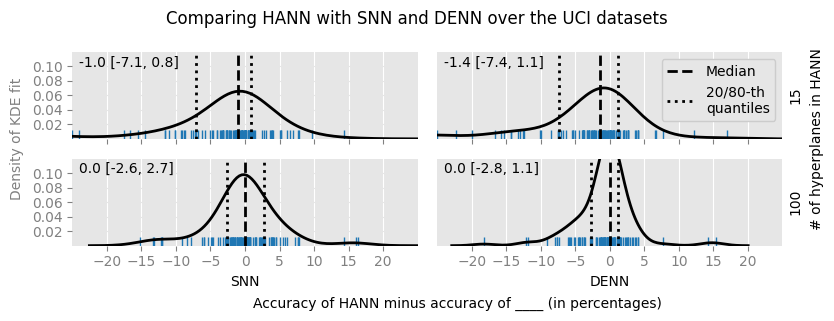

In [10]:
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

fig, axs = plt.subplots(2, 2,figsize=(8,3))


# figure(figsize=(3, 1), dpi=80)
ax = axs[0,0]
diff_use = 'diff_HANN15_SNN'
plot_ridge_line(joint[diff_use],ax)
ax.set_ylabel('15')
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xticks([5*i for i in range(-4,5)])
ax.set_ylabel("")
ax.set_yticks([0.02*i for i in range(1,6)])

ax = axs[0,1]
diff_use = 'diff_HANN15_DENN'
plot_ridge_line(joint[diff_use],ax)
ax.set_yticks([])
ax.yaxis.set_label_position("right")
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('15')
ax.legend(["Median","20/80-th\nquantiles"],framealpha=1)
ax.set_xticks([5*i for i in range(-4,5)])


ax = axs[1,0]
diff_use = 'diff_HANN100_SNN'
plot_ridge_line(joint[diff_use],ax)
ax.set_xlabel('SNN')
ax.set_ylabel('100')
ax.set_ylabel("")
ax.set_yticks([0.02*i for i in range(1,6)])
ax.set_xticks([5*i for i in range(-4,5)])


ax = axs[1,1]
diff_use = 'diff_HANN100_DENN'
plot_ridge_line(joint[diff_use],ax)
ax.set_xlabel('DENN')
ax.set_yticks([])
ax.set_ylabel("100")
ax.yaxis.set_label_position("right")
ax.set_xticks([5*i for i in range(-4,5)])

fig.text(0.0, 0.55, 'Density of KDE fit', ha='center', va='center', rotation='vertical', color='gray')
fig.text(0.55, 0.0, 'Accuracy of HANN minus accuracy of ____ (in percentages)', ha='center', va='center')
fig.text(1.0, 0.55, '# of hyperplanes in HANN', ha='center', va='center', rotation='vertical')

fig.suptitle("Comparing HANN with SNN and DENN over the UCI datasets")

plt.tight_layout()


savefig('figures/comparisons_OCE.eps',bbox_inches='tight')
plt.show()



# Accuracy table

Generate the accuracy table in Appendix D.

In [11]:
acc_only = joint[["DSName","HANN15OCE","HANN100OCE","SNN","DENN"]].rename(columns={"HANN15OCE":"HANN15", "HANN100OCE":"HANN100"})
acc_only.to_latex('figures/table_OCE.tex',longtable=True,index=False)
acc_only.to_csv('accuracy_table.csv',index=False)